In [1]:
import pandas as pd
import numpy as np
from window_generator import WindowGenerator
from string import ascii_uppercase

Here we generate a dataframe of panel data, with a number of countries and a number of timesteps.

In [2]:
n_countries = 3 # Number of countries can be up to 26, based on the number of letters in the alphabet. 
n_timesteps = 100

country = [c for c in ascii_uppercase[:n_countries]]
time = range(n_timesteps)

idx = pd.MultiIndex.from_product([country,  time], names=['country','time'])

np.random.seed(1)

# Generate event occurrence (80% chance of 0, 20% chance of 1)
event_occurrence = np.random.choice(a=[0, 1], size=(n_countries * n_timesteps), p=[0.8, 0.2])

# Generate propensity scores based on event occurrence
propensity_scores = np.where(
    event_occurrence == 0, 
    np.random.normal(loc=0.4, scale=0.2, size=(n_countries * n_timesteps)),
    np.random.normal(loc=0.6, scale=0.2, size=(n_countries * n_timesteps))
)

# Clip propensity scores to be between 0.01 and 0.99
propensity_scores = np.clip(propensity_scores, 0.01, 0.99)

df = pd.DataFrame({'event':event_occurrence, 'proba_event':propensity_scores}, index = idx).reset_index()

print(f'Number of observations: {df.shape[0]}') 
print(f'Number of countries: {df['country'].nunique()}') 
print(f'Number of timesteps: {df['time'].nunique()}')
print(f'Proportion of events: {df.event.mean().round(3)}')
display(df.head())

Number of observations: 300
Number of countries: 3
Number of timesteps: 100
Proportion of events: 0.223


,country,time,event,proba_event
0,A,0,0,0.448534
1,A,1,0,0.440366
2,A,2,0,0.532204
3,A,3,0,0.758432
4,A,4,0,0.375907


As you can see from the displayed dataframe above, columns `country` and `time` are the unit and time columns for our panel data respectively. The remaining columns are `event` and `proba_event`. `event` indicates whether or not there is an event and `proba_event` indicates the propensity score of the event occurring.

`proba_event` is distributed differently based on whether or not an event occurred. As you can see, events generally have a higher propensity score than when events didn't occur:

<Axes: xlabel='proba_event', ylabel='Percent'>

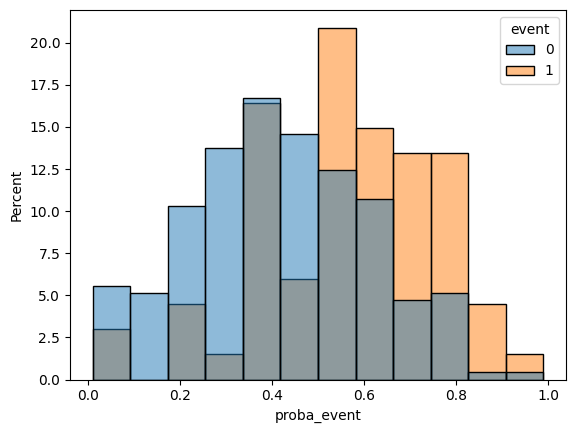

In [3]:
import seaborn as sns
sns.histplot(df, x= 'proba_event', hue='event', common_norm=False, stat='percent')

# WindowGenerator

WindowGenerator lets us:
1. Sample windows around events (treatment windows)
2. Generate matching control windows

Let's see it in action.

## Sample treatment windows

Here we generate a treatment dataframe, based on our parameters we initialized.

In [4]:
from window_generator import WindowGenerator

# We initialize it with some parameters
frame_size = 5
wg = WindowGenerator(DataFrame=df, 
                unit_column='country', 
                time_column='time', 
                treatment_column='event', 
                matching_column='proba_event', 
                frame_size=frame_size,
                buffer_size=0,
                method='nn_propensity_score')

wg.gen_treatment_windows()

Let's take a look at the treatment dataframe we've generated, called `wg.treated_windows`

In [5]:
wg.treated_windows.head(frame_size * 2 + 1)

,country,time,event,proba_event,max_time_by_unit,since_treatment,until_treatment,since_treatment_1,until_treatment_-1,window_id,window_t
0,A,8,0,0.065161,99,9,5.0,8.0,4.0,0.239411,-5
1,A,9,0,0.565006,99,10,4.0,9.0,3.0,0.239411,-4
2,A,10,0,0.300357,99,11,3.0,10.0,2.0,0.239411,-3
3,A,11,0,0.337803,99,12,2.0,11.0,1.0,0.239411,-2
4,A,12,0,0.399622,99,13,1.0,12.0,0.0,0.239411,-1
5,A,13,1,0.802764,99,0,0.0,13.0,6.0,0.239411,0
6,A,14,0,0.227737,99,1,6.0,0.0,5.0,0.239411,1
7,A,15,0,0.534942,99,2,5.0,1.0,4.0,0.239411,2
8,A,16,0,0.523708,99,3,4.0,2.0,3.0,0.239411,3
9,A,17,0,0.311366,99,4,3.0,3.0,2.0,0.239411,4


- max_time_by_unit, since_treatment, until_treatment, since_treatment_1, and until_treatment_-1 are all helper columns.
- window_id is a unique identifier for each window generated
- window_t is the timestep with respect to the event.

In [6]:
print(f'There are {wg.treated_windows.window_id.nunique()} windows in our treated windows dataframe.')

There are 59 windows in our treated windows dataframe.


Within each window there is also the same number of timesteps inside it. Because we initially selected frame_size=5, there are 5 timesteps before the event, the timestep of the event, and then five timesteps afterward:

In [7]:
wg.treated_windows.window_t.value_counts()

window_t
-5    59
-4    59
-3    59
-2    59
-1    59
 0    59
 1    59
 2    59
 3    59
 4    59
 5    59
Name: count, dtype: int64

Buffer size controls whether or not we want to filter for events that don't have other events around them.

In [8]:
from window_generator import WindowGenerator

# We initialize it with some parameters
frame_size = 5
wg_no_buffer = WindowGenerator(DataFrame=df, 
                unit_column='country', 
                time_column='time', 
                treatment_column='event', 
                matching_column='proba_event', 
                frame_size=frame_size,
                buffer_size=0)

wg_no_buffer.gen_treatment_windows()

wg_buffer = WindowGenerator(DataFrame=df, 
                unit_column='country', 
                time_column='time', 
                treatment_column='event', 
                matching_column='proba_event', 
                frame_size=frame_size,
                buffer_size=3)

wg_buffer.gen_treatment_windows()

Once we select a buffer size, this means that we restrict our treated sample to events that don't have events occuring within 3 timesteps.

In [9]:
print(f"window timesteps with events when there isn't a buffer: {wg_no_buffer.treated_windows.query('event == 1').window_t.sort_values().unique()}") 
print(f"window timesteps with events when there is a buffer: {wg_buffer.treated_windows.query('event == 1').window_t.sort_values().unique()}") 

window timesteps with events when there isn't a buffer: [-5 -4 -3 -2 -1  0  1  2  3  4  5]
window timesteps with events when there is a buffer: [-5 -4  0  4  5]


We can also select an asymmetrical frame size and buffer size. Instead of an integer, we pass a list where the first element is the left side and the second element is the right side of the window or buffer.

In [10]:
wg = WindowGenerator(DataFrame=df, 
                unit_column='country', 
                time_column='time', 
                treatment_column='event', 
                matching_column='proba_event', 
                frame_size=[3, 5],
                buffer_size=[1, 3],
                method='nn_propensity_score')
wg.gen_treatment_windows()

print(f'window timesteps: {wg.treated_windows.window_t.unique()}') 
print(f'window timesteps with events: {wg.treated_windows.query('event == 1').window_t.sort_values().unique()}') 

window timesteps: [-3 -2 -1  0  1  2  3  4  5]
window timesteps with events: [-3 -2  0  4  5]


## Generate matching control windows

Let's take a look at how WindowGenerator can create matching control windows.

gen_control_windows finds the **k**-nearest neighbors in the control propensity scores for each event propensity score, 
considering a distance threshold **d** 
and a maximum usage threshold **t** for each control observation.

- k (int): The number of nearest neighbors to find.
- d (float): The maximum distance threshold. Neighbors with a distance larger than this are not considered.
- t (int): The maximum number of times a control observation can be used as a neighbor.



In [11]:
wg = WindowGenerator(DataFrame=df, 
                unit_column='country', 
                time_column='time', 
                treatment_column='event', 
                matching_column='proba_event', 
                frame_size=5,
                buffer_size=3,
                method='nn_propensity_score')
wg.gen_treatment_windows()

wg.gen_control_windows(buffer_size=5, # This means each window will not have any events.
                       k=2, # 2 control neighbors per treated observation
                       d=.2, # The maximum propensity score distance between a treated observation and its corresponding untreated observation.
                       t=10, # Can use a control observation up to 10 times.
                       )
wg.combine_groups() # this combines wg.treated_windows and wg.control_windows in to wg.windows.

In [12]:
wg.control_windows.groupby('window_t').event.mean()

window_t
-5    0.0
-4    0.0
-3    0.0
-2    0.0
-1    0.0
 0    0.0
 1    0.0
 2    0.0
 3    0.0
 4    0.0
 5    0.0
Name: event, dtype: float64

<Axes: xlabel='proba_event', ylabel='Percent'>

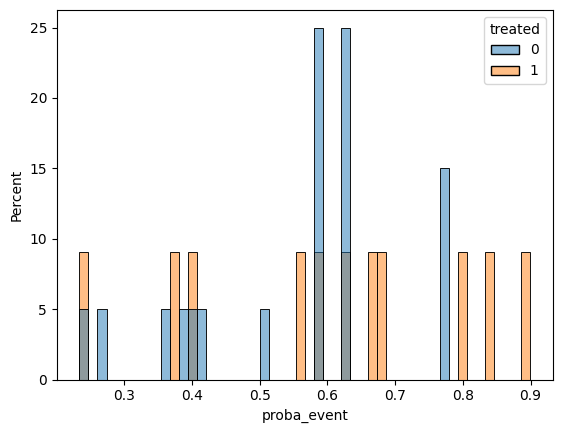

In [13]:
import seaborn as sns

sns.histplot(wg.windows.query('window_t == 0'), x= 'proba_event', hue='treated', stat='percent', common_norm=False, bins=50)

If there isn't enough support for a treated observation according to the parameters specified, it will be dropped.

In [14]:
wg.gen_control_windows(buffer_size=5,
                       k=2, # 2 control neighbors per treated observation
                       d=.05, # The maximum propensity score distance between a treated observation and its corresponding untreated observation.
                       t=3, # Can use a control observation up to 3 times.
                       )
wg.combine_groups()

There are 3 treated observations that do not have support and their windows are being dropped. The following are a sample:
   country  time  proba_event
82       B    71     0.844744
93       B    85     0.899622
16       A    46     0.674491
